
## Predicting Stock Price using RNNs

## Importing the dataset

Mount your drive using the code below.

In [1]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# The first time that you run this cell, you will need to authorize access in your drive. 
# Go to the link and copy the authorization code

Mounted at /content/drive


In [2]:
# Define the directory where your ".csv" file resides on your google drive
# My path is the following (your path will be different): 
fname = '/content/drive/My Drive/MSBA446/data/AAPL2005-2020.csv'

In [3]:
f = open(fname)
data = f.read()
f.close()

data_lines = data.split('\n')     # Each line is 1 recording
header = data_lines[0].split(',') # Variable names are separated by commas
lines = data_lines[1:3958]        # Drop first line (it's a header)

print(header)
print(len(lines))

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
3957


In [4]:
import numpy as np

float_data = np.zeros((len(lines), 4))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:5]]
    float_data[i, :] = values
print(float_data.shape)
# Note that we only keep the following 4 columns: Open, High, Low, Close

(3957, 4)


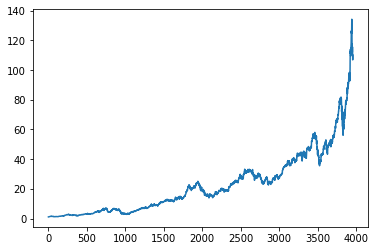

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

close = float_data[:, 3]  # index 3 is close price
plt.plot(range(len(close)), close)

## Input normalization

Since the stock price data (Open, High, Low, Close) are positive numbers, we can divide each column by it's maximum value to make the values between 0 and 1. 

In [7]:
float_data /= float_data.max(axis=0)

In [8]:
float_data

array([[0.00840749, 0.00842643, 0.00856399, 0.00842286],
       [0.008279  , 0.00847302, 0.0086146 , 0.00850936],
       [0.00836595, 0.00844455, 0.00876235, 0.00858389],
       ...,
       [0.7974417 , 0.81316133, 0.83283536, 0.82232823],
       [0.80238393, 0.80359473, 0.81276333, 0.79624386],
       [0.75979362, 0.79859404, 0.78985673, 0.82039058]])

## Data generator

In [9]:
import numpy as np
 
def generator(data, lookback, delay, min_index, max_index, shuffle, batch_size, step, target_index):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    # Out dara generator will generate data indefinitely, so we will have to tell Keras
    # how many batches constitute an epoch ('steps_per_epoch' and 'validation_steps' in model.fit)
    while 1:
        # For the training set (shuffle=True), randomly choose points in time
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        # For the validation and test sets, choose batches of timesteps (in chronological order)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # Batch size
                           lookback // step, # Floor division (e.g., 5//2=2)
                           data.shape[-1]))  # Number of columns in data
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][target_index]
        yield samples, targets

## a recurrent neural network with one `SimpleRNN` layer

 include 128 units in the `SimpleRNN` layer. 


In [10]:
# First, create instances of the data generator as train_gen, val_gen, and test_gen.
lookback = 60
step = 1
delay = 5
batch_size = 64
target_index = 3

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=2000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size,
                      target_index=target_index)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=2001,
                    max_index=3000,
                    shuffle=False,
                    step=step,
                    batch_size=batch_size,
                    target_index=target_index)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=3001,
                     max_index=None,
                     shuffle=False,
                     step=step,
                     batch_size=batch_size,
                     target_index=target_index)


# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (3000 - 2001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 3001 - lookback) // batch_size
#test_steps = (3957 - 300001 - lookback) // batch_size

print(val_steps)
print(test_steps)

14
14


In [11]:
# Then, develop a recurrent neural network with one SimpleRNN layer. 
# For this question, include 128 units in the SimpleRNN layer.
from tensorflow.keras import models
from tensorflow.keras import layers

model1 = models.Sequential()
model1.add(layers.SimpleRNN(128, input_shape=(lookback // step, 4)))

# The output unit have no activation since this is continous prediction
model1.add(layers.Dense(1))




In [12]:
# Compile this model using the Adam optimizer and change the learning rate to 0.0001. 
# Use the appropriate loss function for this problem. During the training process, 
# follow mean absolute percentage error or the mape metric on the train and validation sets. 
# This will give you the percentage error for your stock price predictions.
# model1.compile(optimizer='adam', loss='mse', metrics=['mae'])
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model1.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError()])

In [13]:
# Train your RNN model for 50 epochs. Given that our data generator creates batches of data indefinitely, 
# we will have to tell Keras how many training (validation) batches constitute one training (validation) epoch. 
# To do so, use steps_per_epoch=20 and validation_steps=14.
model1_history = model1.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/50
20/20 [==============================] - 1s 48ms/step - loss: 0.0017 - mean_absolute_error: 0.0277 - val_loss: 0.0020 - val_mean_absolute_error: 0.0355
Epoch 2/50
20/20 [==============================] - 1s 35ms/step - loss: 1.7419e-04 - mean_absolute_error: 0.0108 - val_loss: 9.1888e-04 - val_mean_absolute_error: 0.0242
Epoch 3/50
20/20 [==============================] - 1s 34ms/step - loss: 9.2024e-05 - mean_absolute_error: 0.0071 - val_loss: 6.0254e-04 - val_mean_absolute_error: 0.0197
Epoch 4/50
20/20 [==============================] - 1s 35ms/step - loss: 6.0956e-05 - mean_absolute_error: 0.0055 - val_loss: 4.8263e-04 - val_mean_absolute_error: 0.0178
Epoch 5/50
20/20 [==============================] - 1s 34ms/step - loss: 5.5166e-05 - mean_absolute_error: 0.0051 - val_loss: 4.3391e-04 - val_mean_absolute_error: 0.0171
Epoch 6/50
20/20 [==============================] - 1s 33ms/step - loss: 5.4065e-05 - mean_absolute_error: 0.0051 - val_loss: 2.1262e-04 - val_mean_absol

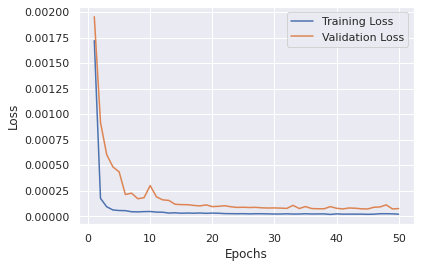

In [14]:
import seaborn as sns
sns.set()

train_loss1 = model1_history.history['loss']
train_mae1 = model1_history.history['mean_absolute_error']
val_loss1 = model1_history.history['val_loss']
val_mae1 = model1_history.history['val_mean_absolute_error']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs, train_loss1, label = 'Training Loss')
plt.plot(epochs, val_loss1, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

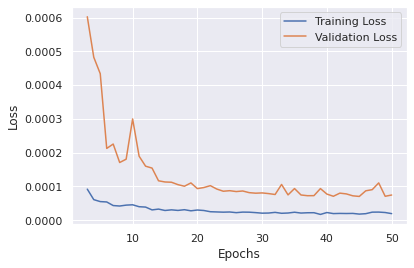

In [15]:
import seaborn as sns
sns.set()

train_loss1 = model1_history.history['loss']
train_mae1 = model1_history.history['mean_absolute_error']
val_loss1 = model1_history.history['val_loss']
val_mae1 = model1_history.history['val_mean_absolute_error']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs[2:], train_loss1[2:], label = 'Training Loss')
plt.plot(epochs[2:], val_loss1[2:], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

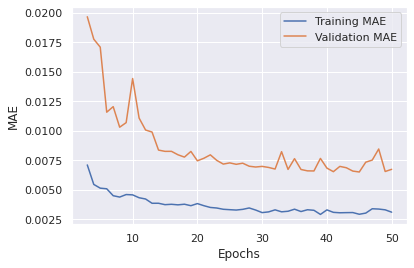

In [16]:
plt.plot(epochs[2:], train_mae1[2:], label = 'Training MAE')
plt.plot(epochs[2:], val_mae1[2:], label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

In [17]:
model1.evaluate(test_gen, steps=test_steps)

14/14 [==============================] - 0s 11ms/step - loss: 0.0013 - mean_absolute_error: 0.0244


[0.0012683005770668387, 0.024405483156442642]

The Mean Absolute Error metric (MAE) is 0.0765. Recall that MAE is simply equal to mean(abs(predictions - targets)). Since our  data has been centered to 1 by devided it's maximum, we have a mae of 0.0765*134.18 =$ 10. 26477

## a recurrent neural network with one `LSTM` layer.

In [ ]:
model2 = models.Sequential()
model2.add(layers.LSTM(128, input_shape=(lookback // step, 4)))
model2.add(layers.Dense(1))

In [ ]:
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model2.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError()])

In [ ]:
model2_history = model2.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/50
20/20 [==============================] - 3s 137ms/step - loss: 0.0023 - mean_absolute_error: 0.0331 - val_loss: 0.0033 - val_mean_absolute_error: 0.0541
Epoch 2/50
20/20 [==============================] - 2s 116ms/step - loss: 4.1215e-04 - mean_absolute_error: 0.0181 - val_loss: 7.9706e-04 - val_mean_absolute_error: 0.0253
Epoch 3/50
20/20 [==============================] - 2s 118ms/step - loss: 1.8097e-04 - mean_absolute_error: 0.0112 - val_loss: 5.1733e-04 - val_mean_absolute_error: 0.0205
Epoch 4/50
20/20 [==============================] - 2s 118ms/step - loss: 7.0302e-05 - mean_absolute_error: 0.0069 - val_loss: 9.1134e-05 - val_mean_absolute_error: 0.0074
Epoch 5/50
20/20 [==============================] - 2s 122ms/step - loss: 3.0768e-05 - mean_absolute_error: 0.0040 - val_loss: 9.2288e-05 - val_mean_absolute_error: 0.0074
Epoch 6/50
20/20 [==============================] - 2s 117ms/step - loss: 2.5800e-05 - mean_absolute_error: 0.0034 - val_loss: 1.1772e-04 - val_mean

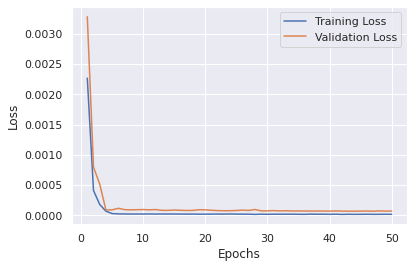

In [ ]:
import seaborn as sns
sns.set()

train_loss2 = model2_history.history['loss']
train_mae2 = model2_history.history['mean_absolute_error']
val_loss2 = model2_history.history['val_loss']
val_mae2 = model2_history.history['val_mean_absolute_error']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs, train_loss2, label = 'Training Loss')
plt.plot(epochs, val_loss2, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

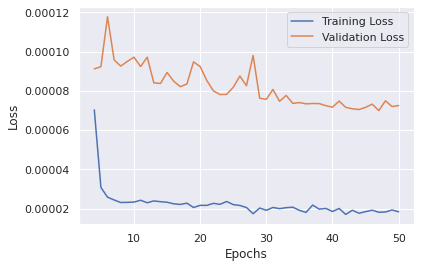

In [ ]:
plt.plot(epochs[3:], train_loss2[3:], label = 'Training Loss')
plt.plot(epochs[3:], val_loss2[3:], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

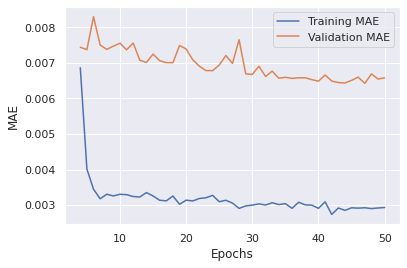

In [ ]:
plt.plot(epochs[3:], train_mae2[3:], label = 'Training MAE')
plt.plot(epochs[3:], val_mae2[3:], label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

In [ ]:
model2.evaluate(test_gen, steps=test_steps)

14/14 [==============================] - 0s 35ms/step - loss: 5.1983e-04 - mean_absolute_error: 0.0166


[0.0005198306171223521, 0.016552308574318886]

The Mean Absolute Error metric (MAE) is 0.0166. Recall that MAE is simply equal to mean(abs(predictions - targets)). Since our data has been centered to 1 by devided it's maximum, we have a mae of 0.0166*134.18 =$ 2.2273

# Try recurrent dropout

In [ ]:
model3 = models.Sequential()
model3.add(layers.LSTM(32,
                      input_shape=(lookback // step, 4),
                      dropout=0.5,
                      recurrent_dropout=0.5))
model3.add(layers.Dense(1))


In [ ]:
model3.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss=losses.MeanSquaredError(),
              metrics=[metrics.MeanAbsoluteError()])

model3_history = model3.fit(train_gen,
                            steps_per_epoch=20,
                            epochs=50,
                            validation_data=val_gen,
                            validation_steps=val_steps)

Epoch 1/50
20/20 [==============================] - 1s 71ms/step - loss: 0.0014 - mean_absolute_error: 0.0252 - val_loss: 0.0038 - val_mean_absolute_error: 0.0593
Epoch 2/50
20/20 [==============================] - 1s 57ms/step - loss: 5.6746e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0011 - val_mean_absolute_error: 0.0305
Epoch 3/50
20/20 [==============================] - 1s 58ms/step - loss: 4.2683e-04 - mean_absolute_error: 0.0164 - val_loss: 7.5418e-04 - val_mean_absolute_error: 0.0253
Epoch 4/50
20/20 [==============================] - 1s 59ms/step - loss: 4.4423e-04 - mean_absolute_error: 0.0156 - val_loss: 6.4395e-04 - val_mean_absolute_error: 0.0233
Epoch 5/50
20/20 [==============================] - 1s 69ms/step - loss: 3.7147e-04 - mean_absolute_error: 0.0139 - val_loss: 4.4460e-04 - val_mean_absolute_error: 0.0191
Epoch 6/50
20/20 [==============================] - 1s 59ms/step - loss: 3.9780e-04 - mean_absolute_error: 0.0140 - val_loss: 2.8717e-04 - val_mean_absolute_

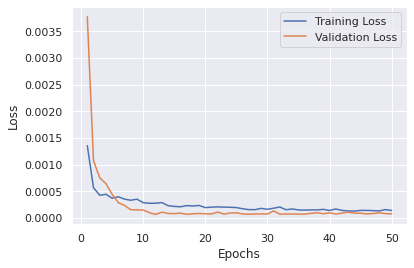

In [ ]:
import seaborn as sns
sns.set()

train_loss3 = model3_history.history['loss']
train_mae3 = model3_history.history['mean_absolute_error']
val_loss3 = model3_history.history['val_loss']
val_mae3 = model3_history.history['val_mean_absolute_error']

epochs = range(1, len(train_loss1) + 1)

plt.plot(epochs, train_loss3, label = 'Training Loss')
plt.plot(epochs, val_loss3, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

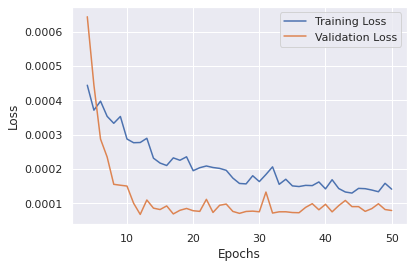

In [ ]:
plt.plot(epochs[3:], train_loss3[3:], label = 'Training Loss')
plt.plot(epochs[3:], val_loss3[3:], label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

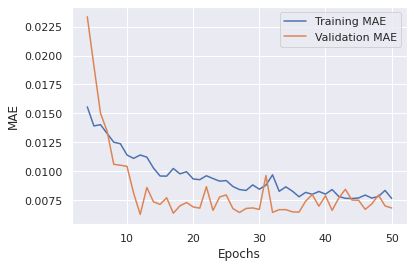

In [ ]:
plt.plot(epochs[3:], train_mae3[3:], label = 'Training MAE')
plt.plot(epochs[3:], val_mae3[3:], label = 'Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

In [ ]:
model3.evaluate(test_gen, steps=test_steps)

14/14 [==============================] - 0s 9ms/step - loss: 0.0031 - mean_absolute_error: 0.0394


[0.0031119571067392826, 0.03938179090619087]